In [26]:
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

### Preparacion de Data

In [27]:
# Rescalar imágenes
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocesamiento de imágenes para entreno y validación
train_generator = train_data_gen.flow_from_directory(
    './data/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical'
)

test_generator = validation_data_gen.flow_from_directory(
    './data/test',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Arquitectura de Modelo

In [28]:
# Arqui de modelo
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), name='CONV1'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='CONV2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='POOL1'))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='CONV3'))
model.add(MaxPooling2D(pool_size=(2, 2), name='POOL2'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='CONV4'))
model.add(MaxPooling2D(pool_size=(2, 2), name='POOL3'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu', name='FULLY'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax', name='SOPFTMAX'))

cv2.ocl.setUseOpenCL(False)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(
        # lr=0.0001,
        # decay=1e-6
    ), 
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 46, 46, 32)        320       
                                                                 
 CONV2 (Conv2D)              (None, 44, 44, 64)        18496     
                                                                 
 POOL1 (MaxPooling2D)        (None, 22, 22, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 CONV3 (Conv2D)              (None, 20, 20, 128)       73856     
                                                                 
 POOL2 (MaxPooling2D)        (None, 10, 10, 128)       0         
                                                                 
 CONV4 (Conv2D)              (None, 8, 8, 128)        

## Entrenamiento de modelo

In [29]:
# Entrenar
history = model.fit(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=60,
    validation_data=test_generator,
    validation_steps=7178 // 64
)

Epoch 1/60
448/448 [==============================] - 291s 646ms/step - loss: 1.7414 - accuracy: 0.2909 - val_loss: 1.5108 - val_accuracy: 0.4082
Epoch 2/60
448/448 [==============================] - 132s 295ms/step - loss: 1.4300 - accuracy: 0.4472 - val_loss: 1.2991 - val_accuracy: 0.5003
Epoch 3/60
448/448 [==============================] - 123s 275ms/step - loss: 1.2810 - accuracy: 0.5069 - val_loss: 1.2222 - val_accuracy: 0.5346
Epoch 4/60
448/448 [==============================] - 135s 302ms/step - loss: 1.2043 - accuracy: 0.5398 - val_loss: 1.1545 - val_accuracy: 0.5587
Epoch 5/60
448/448 [==============================] - 141s 314ms/step - loss: 1.1504 - accuracy: 0.5607 - val_loss: 1.1224 - val_accuracy: 0.5759
Epoch 6/60
448/448 [==============================] - 140s 313ms/step - loss: 1.1100 - accuracy: 0.5780 - val_loss: 1.1069 - val_accuracy: 0.5809
Epoch 7/60
448/448 [==============================] - 140s 313ms/step - loss: 1.0744 - accuracy: 0.5893 - val_loss: 1.0915 -

### Métricas de Desempeño

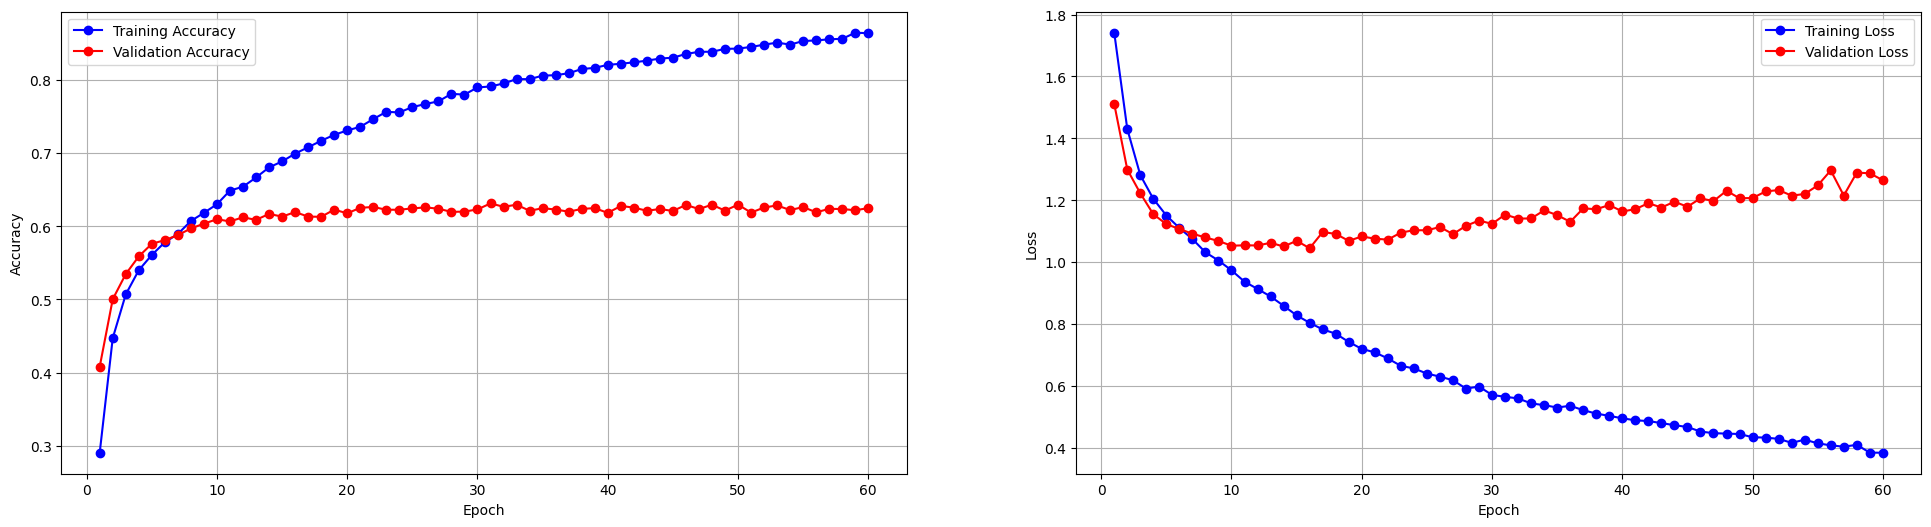

Best Validation Accuracy Score 0.63100, is for epoch 31


In [30]:
import matplotlib.pyplot as plt

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))

    # Plotting Training and Validation Accuracy with markers
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')  # 'bo-' means blue color, circle marker, solid line
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')  # 'ro-' means red color, circle marker, solid line
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plotting Training and Validation Loss with markers
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')  # 'bo-' means blue color, circle marker, solid line
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # 'ro-' means red color, circle marker, solid line
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)
    print(f'Best Validation Accuracy Score {best_acc}, is for epoch {best_epoch}')
    return best_epoch

plot_results(history)
best_epoch = get_best_epcoh(history)

1/1 [==============================] - 0s 84ms/step


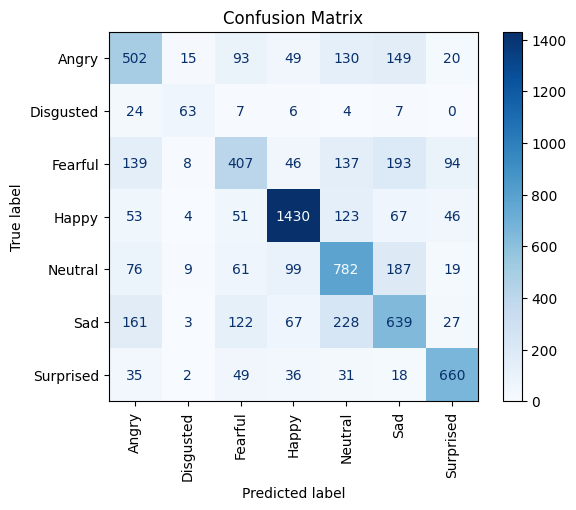

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def get_true_and_pred_labels(model, generator):
    # Get the number of batches in the generator
    num_batches = len(generator)
    
    # Initialize empty arrays to hold true and predicted labels
    true_labels = []
    pred_labels = []

    # Iterate over the generator and get predictions
    for i in range(num_batches):
        x_batch, y_batch = generator[i]
        y_pred = model.predict(x_batch)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_batch, axis=1)
        
        true_labels.extend(y_true_classes)
        pred_labels.extend(y_pred_classes)
    
    return np.array(true_labels), np.array(pred_labels)

def plot_confusion_matrix(model, test_generator, class_names):
    # Get true and predicted labels
    y_true, y_pred = get_true_and_pred_labels(model, test_generator)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
    plt.show()

plot_confusion_matrix(
    model,
    test_generator,
    ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised"],
)

### Guardar pesos del modelo para futuros usos

In [33]:

# Guardar modelo
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')
